## Word embedding using mBERT with data preporcessing

### 1. Set up environment with the necessary libraries and load CSV data

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from datetime import datetime

# Load the dataset
# df = pd.read_csv('test_gr/test.csv')
# encoding utf-8 is called in order to read the ultillingual csv file properly 
df = pd.read_csv('steam_reviews.csv', encoding='utf-8')

# Display the first few rows to understand the structure
df.head(10)

C:\Users\ngyij\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\ngyij\AppData\Local\Temp\ipykernel_9412\2086186063.py:14: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('steam_reviews.csv', encoding='utf-8')


,Unnamed: 0,app_id,app_name,review_id,language,review_text,voted_up,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,0,2397380,The Cold Hand,138284361,english,"""Yeah man, I'm making a game. It's gonna be a ...",False,2023-05-14 10:54:21,2023-05-16 09:14:07,3,0,0.552239,0,False,False,False,True,NaN
1,1,2397380,The Cold Hand,137869845,english,I like the part where you jump on enemies and ...,True,2023-05-06 08:16:29,2023-05-06 08:16:29,2,0,0.531250,0,False,False,False,True,NaN
2,2,2397380,The Cold Hand,137856344,japanese,[h1]やたらとエンディングはある[/h1]\n死んだ時にびっくり要素があるので最初だけ注意...,True,2023-05-06 01:13:49,2023-05-06 01:14:34,1,0,0.508197,0,False,False,False,True,NaN
3,3,2397400,Unnatural Season Two,137882379,english,"To be perfectly honest, it ends up feeling lik...",False,2023-05-06 13:30:52,2023-05-06 23:01:36,12,0,0.671914,0,True,False,False,True,NaN
4,4,2397400,Unnatural Season Two,138491433,english,"Didn't know this was planned as a series, so h...",True,2023-05-18 14:34:00,2023-05-18 14:34:00,1,0,0.521739,0,True,False,False,True,NaN
5,5,2397560,ファミレスを享受せよ サウンドトラック,143955538,japanese,ループ再生でもゲームプレイ中と大体同じような感覚でループしてくれるサウンドトラック。\n意識...,True,2023-08-12 03:55:49,2023-08-12 03:55:49,6,0,0.615385,0,True,False,False,True,NaN
6,6,2397580,My Pleasure - Season 2: Advanced Walkthrough,140706437,english,how do you even open this walkthrough,False,2023-06-26 00:01:49,2023-06-26 00:01:49,0,0,0.438675,0,True,False,False,True,NaN
7,7,2397580,My Pleasure - Season 2: Advanced Walkthrough,141458332,german,a walkthrough is always good to have,True,2023-07-06 16:06:40,2023-07-06 16:06:40,0,0,0.000000,0,True,False,False,True,NaN
8,8,2397690,Blooby Block,140219133,russian,[h1] Головоломные поиски выхода [/h1]\nhttps:/...,True,2023-06-17 14:23:03,2023-06-17 14:27:55,30,1,0.696298,7,False,True,False,True,NaN
9,9,2397690,Blooby Block,139789971,japanese,[h1]考えがいのあるパズルゲーム[/h1]\n日本語未対応（言語依存度低）\n\nいわゆる...,True,2023-06-09 16:21:20,2023-06-25 14:07:35,8,1,0.608313,0,False,True,False,True,NaN


### 2. Data preprocessing

In [2]:
# Data Preprocessing
def preprocess_data(df):
    # Create a copy to avoid modifying the original
    clean_df = df.copy()
    
    # Convert timestamps to datetime objects
    # Check if timestamps are already in datetime string format
    if isinstance(clean_df['timestamp_created'].iloc[0], str):
        # If they're strings that look like dates, convert directly
        clean_df['timestamp_created'] = pd.to_datetime(clean_df['timestamp_created'])
        clean_df['timestamp_updated'] = pd.to_datetime(clean_df['timestamp_updated'])
    else:
        # If they're numeric (Unix timestamps), use unit='s'
        clean_df['timestamp_created'] = pd.to_datetime(clean_df['timestamp_created'], unit='s')
        clean_df['timestamp_updated'] = pd.to_datetime(clean_df['timestamp_updated'], unit='s')
    
    # Extract year from timestamp
    clean_df['year'] = clean_df['timestamp_created'].dt.year
    
    # Clean review text
    clean_df['clean_review'] = clean_df['review_text'].apply(clean_text)
    
    # Drop rows with empty reviews after cleaning
    clean_df = clean_df[clean_df['clean_review'].str.strip() != '']
    
    # Remove duplicates based on review_id
    clean_df = clean_df.drop_duplicates(subset=['review_id'])
    
    # Convert voted_up to a sentiment label
    clean_df['sentiment'] = clean_df['voted_up'].map({True: 'Positive', False: 'Negative'})
    
    return clean_df


def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters but keep spaces between words
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [3]:
# Apply preprocessing
processed_df = preprocess_data(df)
print(f"Original dataset: {len(df)} rows")
print(f"Processed dataset: {len(processed_df)} rows")

Original dataset: 369878 rows
Processed dataset: 366649 rows


### 2. Implement multilingual BERT for word embeddings

In [4]:
# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

In [5]:
# Function to get embeddings in batches using GPU
def get_bert_embeddings_batch(texts, batch_size=32):
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Initialize an array to store all embeddings
    all_embeddings = []
    
    # Process in batches
    for i in range(0, len(texts), batch_size):
        # Get batch texts
        batch_texts = texts[i:i+batch_size]
        
        # Handle non-string or empty inputs
        valid_texts = []
        invalid_indices = []
        for j, text in enumerate(batch_texts):
            if not isinstance(text, str) or not text.strip():
                invalid_indices.append(j)
            else:
                valid_texts.append(text)
        
        # If no valid texts in this batch, add zero vectors
        if not valid_texts:
            batch_embeddings = [np.zeros(768) for _ in range(len(batch_texts))]
            all_embeddings.extend(batch_embeddings)
            continue
        
        # Tokenize the valid texts
        encoded_input = tokenizer(valid_texts, padding=True, truncation=True, 
                                  max_length=512, return_tensors='pt')
        
        # Move inputs to GPU
        encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
        
        # Get model output (without gradient calculation)
        with torch.no_grad():
            outputs = model(**encoded_input)
        
        # Get CLS token embeddings and move to CPU for numpy conversion
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        
        # Reinsert zero vectors for invalid texts
        final_batch_embeddings = []
        valid_idx = 0
        for j in range(len(batch_texts)):
            if j in invalid_indices:
                final_batch_embeddings.append(np.zeros(768))
            else:
                final_batch_embeddings.append(batch_embeddings[valid_idx])
                valid_idx += 1
        
        all_embeddings.extend(final_batch_embeddings)
        
        # Print progress
        if (i // batch_size) % 10 == 0:
            print(f"Processed {i+len(batch_texts)}/{len(texts)} texts")
    
    return np.array(all_embeddings)

In [6]:
# Convert the Series to a list first
review_texts = processed_df['clean_review'].tolist()
all_embeddings = get_bert_embeddings_batch(review_texts, batch_size=32)

# Assign the embeddings back to the dataframe
processed_df['embedding'] = list(all_embeddings)

Processed 32/366649 texts
Processed 352/366649 texts
Processed 672/366649 texts
Processed 992/366649 texts
Processed 1312/366649 texts
Processed 1632/366649 texts
Processed 1952/366649 texts
Processed 2272/366649 texts
Processed 2592/366649 texts
Processed 2912/366649 texts
Processed 3232/366649 texts
Processed 3552/366649 texts
Processed 3872/366649 texts
Processed 4192/366649 texts
Processed 4512/366649 texts
Processed 4832/366649 texts
Processed 5152/366649 texts
Processed 5472/366649 texts
Processed 5792/366649 texts
Processed 6112/366649 texts
Processed 6432/366649 texts
Processed 6752/366649 texts
Processed 7072/366649 texts
Processed 7392/366649 texts
Processed 7712/366649 texts
Processed 8032/366649 texts
Processed 8352/366649 texts
Processed 8672/366649 texts
Processed 8992/366649 texts
Processed 9312/366649 texts
Processed 9632/366649 texts
Processed 9952/366649 texts
Processed 10272/366649 texts
Processed 10592/366649 texts
Processed 10912/366649 texts
Processed 11232/366649

Processed 90912/366649 texts
Processed 91232/366649 texts
Processed 91552/366649 texts
Processed 91872/366649 texts
Processed 92192/366649 texts
Processed 92512/366649 texts
Processed 92832/366649 texts
Processed 93152/366649 texts
Processed 93472/366649 texts
Processed 93792/366649 texts
Processed 94112/366649 texts
Processed 94432/366649 texts
Processed 94752/366649 texts
Processed 95072/366649 texts
Processed 95392/366649 texts
Processed 95712/366649 texts
Processed 96032/366649 texts
Processed 96352/366649 texts
Processed 96672/366649 texts
Processed 96992/366649 texts
Processed 97312/366649 texts
Processed 97632/366649 texts
Processed 97952/366649 texts
Processed 98272/366649 texts
Processed 98592/366649 texts
Processed 98912/366649 texts
Processed 99232/366649 texts
Processed 99552/366649 texts
Processed 99872/366649 texts
Processed 100192/366649 texts
Processed 100512/366649 texts
Processed 100832/366649 texts
Processed 101152/366649 texts
Processed 101472/366649 texts
Processed

Processed 178912/366649 texts
Processed 179232/366649 texts
Processed 179552/366649 texts
Processed 179872/366649 texts
Processed 180192/366649 texts
Processed 180512/366649 texts
Processed 180832/366649 texts
Processed 181152/366649 texts
Processed 181472/366649 texts
Processed 181792/366649 texts
Processed 182112/366649 texts
Processed 182432/366649 texts
Processed 182752/366649 texts
Processed 183072/366649 texts
Processed 183392/366649 texts
Processed 183712/366649 texts
Processed 184032/366649 texts
Processed 184352/366649 texts
Processed 184672/366649 texts
Processed 184992/366649 texts
Processed 185312/366649 texts
Processed 185632/366649 texts
Processed 185952/366649 texts
Processed 186272/366649 texts
Processed 186592/366649 texts
Processed 186912/366649 texts
Processed 187232/366649 texts
Processed 187552/366649 texts
Processed 187872/366649 texts
Processed 188192/366649 texts
Processed 188512/366649 texts
Processed 188832/366649 texts
Processed 189152/366649 texts
Processed 

Processed 266592/366649 texts
Processed 266912/366649 texts
Processed 267232/366649 texts
Processed 267552/366649 texts
Processed 267872/366649 texts
Processed 268192/366649 texts
Processed 268512/366649 texts
Processed 268832/366649 texts
Processed 269152/366649 texts
Processed 269472/366649 texts
Processed 269792/366649 texts
Processed 270112/366649 texts
Processed 270432/366649 texts
Processed 270752/366649 texts
Processed 271072/366649 texts
Processed 271392/366649 texts
Processed 271712/366649 texts
Processed 272032/366649 texts
Processed 272352/366649 texts
Processed 272672/366649 texts
Processed 272992/366649 texts
Processed 273312/366649 texts
Processed 273632/366649 texts
Processed 273952/366649 texts
Processed 274272/366649 texts
Processed 274592/366649 texts
Processed 274912/366649 texts
Processed 275232/366649 texts
Processed 275552/366649 texts
Processed 275872/366649 texts
Processed 276192/366649 texts
Processed 276512/366649 texts
Processed 276832/366649 texts
Processed 

Processed 354272/366649 texts
Processed 354592/366649 texts
Processed 354912/366649 texts
Processed 355232/366649 texts
Processed 355552/366649 texts
Processed 355872/366649 texts
Processed 356192/366649 texts
Processed 356512/366649 texts
Processed 356832/366649 texts
Processed 357152/366649 texts
Processed 357472/366649 texts
Processed 357792/366649 texts
Processed 358112/366649 texts
Processed 358432/366649 texts
Processed 358752/366649 texts
Processed 359072/366649 texts
Processed 359392/366649 texts
Processed 359712/366649 texts
Processed 360032/366649 texts
Processed 360352/366649 texts
Processed 360672/366649 texts
Processed 360992/366649 texts
Processed 361312/366649 texts
Processed 361632/366649 texts
Processed 361952/366649 texts
Processed 362272/366649 texts
Processed 362592/366649 texts
Processed 362912/366649 texts
Processed 363232/366649 texts
Processed 363552/366649 texts
Processed 363872/366649 texts
Processed 364192/366649 texts
Processed 364512/366649 texts
Processed 

### 3. Visualiation of the result

In [12]:
# Convert list of embeddings to a 2D numpy array
embeddings_array = np.stack(processed_df['embedding'].values)

# Use PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)

# Add reduced embeddings as new columns
processed_df['pca_1'] = reduced_embeddings[:, 0]
processed_df['pca_2'] = reduced_embeddings[:, 1]


C:\Users\ngyij\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


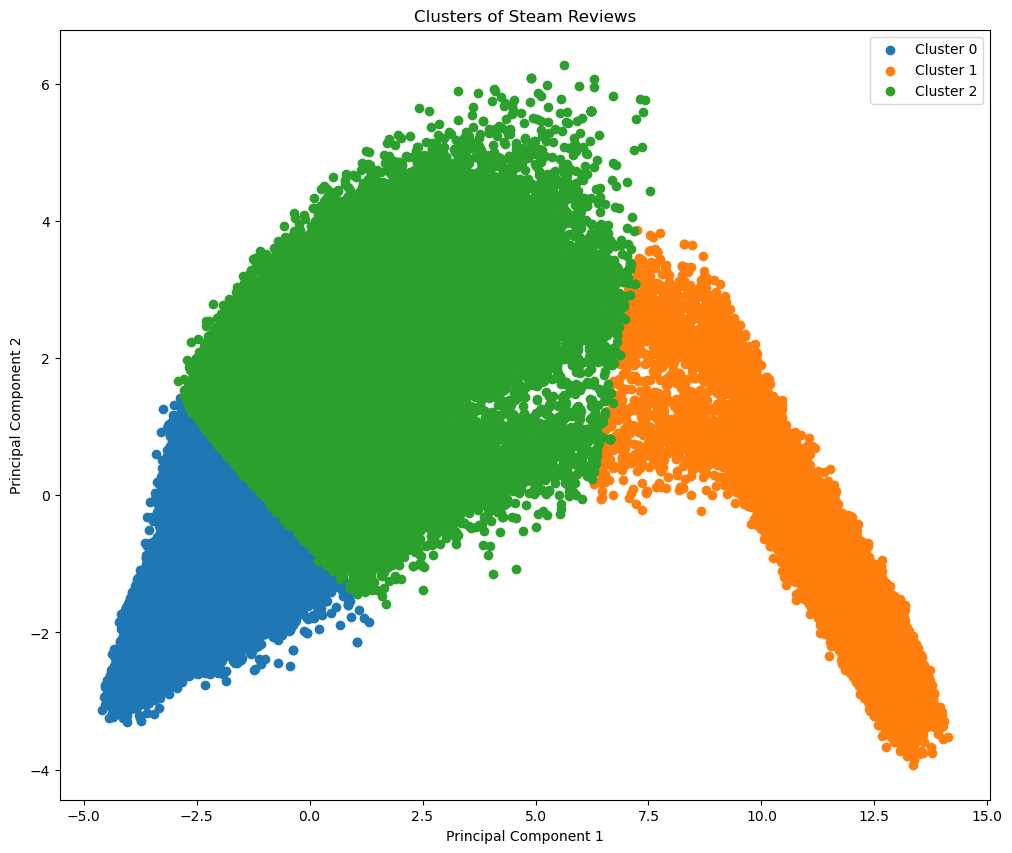

In [13]:
# Cluster the embeddings
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
processed_df['cluster'] = kmeans.fit_predict(embeddings_array)

# Visualize clusters
plt.figure(figsize=(12, 10))
for cluster in range(num_clusters):
    cluster_points = processed_df[processed_df['cluster'] == cluster]
    plt.scatter(cluster_points['pca_1'], cluster_points['pca_2'], label=f'Cluster {cluster}')

plt.title('Clusters of Steam Reviews')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
# plt.savefig('clusters_visualization.png')
plt.show()

In [15]:
# Print examples from each cluster
for cluster_id in range(num_clusters):
    print(f"\n=== CLUSTER {cluster_id} EXAMPLES ===")
    
    # Get reviews from this cluster
    cluster_reviews = processed_df[processed_df['cluster'] == cluster_id]
    
    # Get cluster stats
    print(f"Number of reviews: {len(cluster_reviews)}")
    print(f"Languages: {cluster_reviews['language'].value_counts().head(5).to_dict()}")
    print(f"Sentiment distribution: {cluster_reviews['sentiment'].value_counts().to_dict()}")
    
    # Sample 3 reviews from this cluster (or fewer if cluster has less than 3)
    sample_size = min(3, len(cluster_reviews))
    samples = cluster_reviews.sample(sample_size)
    
    # Print each sample with relevant information
    for i, (_, row) in enumerate(samples.iterrows()):
        print(f"\nExample {i+1}:")
        print(f"Game: {row['app_name']}")
        print(f"Language: {row['language']}")
        print(f"Sentiment: {row['sentiment']}")
        print(f"Review: {row['review_text'][:200]}..." if len(row['review_text']) > 200 else f"Review: {row['review_text']}")
        print("-" * 50)


=== CLUSTER 0 EXAMPLES ===
Number of reviews: 172964
Languages: {'schinese': 56230, 'english': 25538, 'russian': 25150, 'koreana': 9717, 'brazilian': 8307}
Sentiment distribution: {'Positive': 131656, 'Negative': 41308}

Example 1:
Game: Minions Battle
Language: turkish
Sentiment: Positive
Review: Oyuncu yok :/
--------------------------------------------------

Example 2:
Game: SWORD ART ONLINE Alicization Lycoris - Blooming of Forget-me-not
Language: japanese
Sentiment: Positive
Review: ストーリー ★★★★★★★★☆☆
動画 ★★☆☆☆☆☆☆☆☆
ゲームシステム　★★★★★☆☆☆☆☆

昨日、古の使徒すべて400にレベルアップしました、まだ完成品の[石蓮華の首飾り]と[奈落の指輪]を入手いない。レアアイテムけど…このドロップ率はちょっとひどね～めっちゃ。
--------------------------------------------------

Example 3:
Game: 星礼研究所 | Sighchology Research Lab
Language: schinese
Sentiment: Positive
Review: 辛辛苦苦读了30篇文献，咔嚓闪退没保存就没了
我们设计狗想跨学科搞搞心理怎么这么难（认真脸.jpg）
——————“游戏测评结束”——————
这个小游戏虽然很枯燥
但是看了评论发现大家都太不容易啦
有时候放松一下自己真的很关键
祝所有看见评论的人，paper多多，成果多多
——————“此处锦鲤在转”——————
--------------------------------------------------

=== CLUS

### 4. Justification and Analysis

#### a. mBERT embedding specification:
- Running time: 1.5 hrs
- Resource: CUDA core using RTX 3060
- Optimisation technique applied: Batching

#### b. Cluster 0: 
Visualise in blue color
Size: 172,964 reviews
Languages: Dominated by Chinese, English, and Russian content but also containing significanot amount of koreana and brazilian
Sentiment: 76% Positive (131,656) vs. 24% Negative (41,308)
Possible Interpretation:

- This cluster contains a diverse mix of languages, notably Asian (Chinese, Japanese, Korean) and some European (Russian, Turkish).
- Many reviews go beyond simple praise or criticism—they contain detailed discussions on gameplay, mechanics, and user frustrations.
- The large number of positive reviews (76%) may indicate that this cluster contains invested players who provide constructive feedback rather than outright complaints.
- Reviews may be more nuanced and regionally specific, highlighting different player expectations across cultures.

#### c. Cluster 1: 
Visualise in orange color
Size: 34,594 reviews (smallest cluster).
Languages: Dominated by English.
Sentiment: 71% Positive (24,532) vs. 29% Negative (10,062).
Possible Interpretation:

- A smaller, more critical cluster compared to the others.
- A lot of English-speaking reviews, but more balance in sentiment (71% positive, 29% negative) compared to Cluster 0.
- Reviews are longer and more detailed, with players weighing pros and cons rather than leaving short reactions.
- Likely represents players who are more involved in the gaming community, including those actively reporting bugs or expecting high standards.

#### d. Cluster 2: 
Visualise in green color
Size: 159,091 reviews.
Languages: Mostly English (137,789), with smaller amounts of Russian (3,945) and German (3,773).
Sentiment: 78% Positive (123,450) vs. 22% Negative (35,641).
Possible Interpretation:

- This cluster is dominated by English-language reviews, possibly casual or short-form reviews.
- Reviews tend to be short and direct (e.g., “meh,” “Fun game”).
- High positivity (78%) suggests this may contain more casual players who either like a game or don’t engage deeply.
- The presence of idle/survival game reviews suggests this cluster may consist of casual gamers who leave brief but positive feedback.